## 🚀 **Run All: Data Analysis and Visualisation**  

This notebook automates tasks such as **raw signal plotting**, **FFT processing**, **spectrogram generation**, and **feature extraction** across one or multiple events. Click run all to generate all dataframes, features and plotters 

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.stats import skew, kurtosis
import librosa.display


# Load the JSON file
file_path = '../../tests/testData/testDataVisualisation.json'  # Replace with your JSON file path
with open(file_path, 'r') as file:
    raw_json = json.load(file)

## **1: Meta Data** 📈  

In [2]:
# Flatten the JSON and extract relevant fields
flattened_data = []

for attribute in raw_json:
    # Extract user_id
    user_id = attribute.get('userId', None)
    datapoints = attribute.get('datapoints', [])
    subtype = attribute.get('subType', None)
    stype = attribute.get('type', None)
    desc = attribute.get('desc', None)    
    seizureTimes = attribute.get('seizureTimes', [])
    sampleFreq = attribute.get('sampleFreq', 25)
    watchSdName = attribute.get('watchSdName', None)


    for point in datapoints:
        eventId = point.get('eventId', None)
        #hrAlarmActive = attribute.get('hrAlarmActive', None)
        #o2SatAlarmActive = attribute.get('o2SatAlarmActive', None)
        #dataSourceName = attribute.get('dataSourceName', None)
        #watchSdName= attribute.get('watchSdName', None)

        
    # Append the flattened structure
    flattened_data.append({
        'eventId': eventId,
        'userId': user_id,
        'subtype': subtype,
        'type': stype,
        'desc':desc,
        'seizureTimes': seizureTimes,
        'sampleFreq': sampleFreq,
        #"hrAlarmActive": hrAlarmActive, 
        #"o2SatAlarmActive": o2SatAlarmActive, 
        'watchSdName': watchSdName, 
        

    })

    # Create a DataFrame
df_metadata = pd.DataFrame(flattened_data)
df_metadata.to_csv('generatedCsvDatasets/metadata.csv', index=False)
# Display the DataFrame
df_metadata.head()

,eventId,userId,subtype,type,desc,seizureTimes,sampleFreq,watchSdName
0,407,39,Other,Seizure,twisting to left. right arm flapping. left a...,"[-38.0, 76.0]",25,None
1,764,39,Other,Seizure,"kneeling up, looking to right","[-35.0, 75.0]",25,None
2,4924,39,Other,Seizure,on back. left arm flapping,"[-25.0, 60.0]",25,None
3,5483,39,Tonic-Clonic,Seizure,null,"[-45.0, 35.0]",25,GarminSD
4,5486,39,Tonic-Clonic,Seizure,null,"[-15.0, 60.0]",25,GarminSD


## **2: Sensor Data** 📈  

In [3]:
# Flatten the JSON and extract relevant fields
flattened_data = []

for attribute in raw_json:
    user_id = attribute.get('userId', None)
    seizure_times = attribute.get('seizureTimes', [])
    datapoints = attribute.get('datapoints', [])

    for point in datapoints:
        event_id = point.get('eventId', None)
        hr = point.get('hr', [])
        o2Sat = point.get('o2Sat', [])
        rawData = point.get('rawData', [])
        rawData3D = point.get('rawData3D', [])
        # Append every datapoint as a row
        flattened_data.append({
            'eventId': event_id,
            'userId': user_id,
            'hr': hr,
            'o2Sat': o2Sat,
            'rawData': rawData,
            'rawData3D': rawData3D,

        })

# Create a DataFrame
df_sensordata = pd.DataFrame(flattened_data)
df_sensordata.to_csv('generatedCsvDatasets/sensordata.csv', index=False)

# Display the DataFrame
df_sensordata.head()



,eventId,userId,hr,o2Sat,rawData,rawData3D
0,407,39,67,-1,"[1496, 1480, 1500, 1492, 1496, 1484, 1500, 149...",[]
1,407,39,67,-1,"[1492, 1508, 1496, 1476, 1484, 1476, 1496, 150...",[]
2,407,39,68,-1,"[1488, 1496, 1484, 1492, 1492, 1508, 1504, 148...",[]
3,407,39,69,-1,"[1488, 1476, 1480, 1504, 1496, 1508, 1484, 148...",[]
4,407,39,69,-1,"[1504, 1488, 1504, 1492, 1484, 1500, 1496, 149...",[]


## **3: Sensor Data with FFT** 📈  

In [4]:
# Sampling frequency (25 Hz as per your clarification)
sampling_rate = 25  # in Hz

# Define FFT calculation function for each row
def calculate_fft(raw_data):
    # Remove the DC component (mean of the signal)
    raw_data = raw_data - np.mean(raw_data)
    
    # Compute the Fourier Transform (FFT) for the entire signal
    fft_result = np.fft.fft(raw_data)
    
    # Compute the frequencies corresponding to the FFT result
    frequencies = np.fft.fftfreq(len(raw_data), d=1/sampling_rate)
    
    # Compute the magnitude of the FFT (absolute value)
    fft_magnitude = np.abs(fft_result)
    
    # Only consider the positive frequencies (the FFT is symmetric)
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_fft_magnitude = fft_magnitude[:len(frequencies)//2]
    
    return positive_frequencies, positive_fft_magnitude

# Add a new column for FFT data for all rows in the DataFrame
fft_results = []

for _, row in df_sensordata.iterrows():
    # Extract rawData for the row
    raw_data = np.array(row['rawData'])
    
    # Calculate the FFT for the current row
    positive_frequencies, positive_fft_magnitude = calculate_fft(raw_data)
    
    # Store the result as a list of FFT magnitudes
    fft_results.append(list(positive_fft_magnitude))  # Modify if needed to store specific frequency ranges

# Add the FFT results to the DataFrame as a new column
df_sensordata['FFT'] = fft_results

# Optionally, you can view the DataFrame to confirm the FFT column has been added

df_sensordata.to_csv('generatedCsvDatasets/sensordata_fft.csv', index=False)

df_sensordata.sample()

,eventId,userId,hr,o2Sat,rawData,rawData3D,FFT
1337,7125,45,75,-1,"[1714, 1736, 1725, 1723, 1725, 1711, 1726, 171...",[],"[3.183231456205249e-12, 514.7892755464219, 385..."


## **4: Extracted Features** 📈  

In [5]:
# Sample data (you already have the DataFrame 'df_sensordata' containing all rows)
# df_sensordata = ...  # Make sure to load your data here if not already loaded.

# Sampling frequency (25 Hz as per your clarification)
sampling_rate = 25  # in Hz

# Define FFT calculation function for each row
def calculate_fft(raw_data):
    # Remove the DC component (mean of the signal)
    raw_data = raw_data - np.mean(raw_data)
    
    # Compute the Fourier Transform (FFT) for the entire signal
    fft_result = np.fft.fft(raw_data)
    
    # Compute the frequencies corresponding to the FFT result
    frequencies = np.fft.fftfreq(len(raw_data), d=1/sampling_rate)
    
    # Compute the magnitude of the FFT (absolute value)
    fft_magnitude = np.abs(fft_result)
    
    # Only consider the positive frequencies (the FFT is symmetric)
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_fft_magnitude = fft_magnitude[:len(frequencies)//2]
    
    return positive_frequencies, positive_fft_magnitude

# Add a new column for FFT data for all rows in the DataFrame
fft_results = []

for _, row in df_sensordata.iterrows():
    # Extract rawData for the row
    raw_data = np.array(row['rawData'])
    
    # Calculate the FFT for the current row
    positive_frequencies, positive_fft_magnitude = calculate_fft(raw_data)
    
    # Store the result as a list of FFT magnitudes
    fft_results.append(list(positive_fft_magnitude))  # Modify if needed to store specific frequency ranges

# Add the FFT results to the DataFrame as a new column
df_sensordata['FFT'] = fft_results

# Optionally, you can view the DataFrame to confirm the FFT column has been added
df_sensordata.head()



# Sampling frequency (25 Hz)
sampling_rate = 25  # in Hz



# Function to calculate total distance for rawData
def calculate_total_distance(raw_data):
    # Convert from milli-g to m/s² (milli-g * 9.81 / 1000)
    raw_data_m_s2 = raw_data * (9.81 / 1000)
    
    # Calculate time step (1 / sampling rate)
    time_step = 1 / sampling_rate
    
    # Calculate distance traveled for each timestep: d = 0.5 * a * t^2
    # We square the time step and multiply by 0.5 times the acceleration
    distance_traveled = 0.5 * raw_data_m_s2 * time_step**2
    
    # Sum the distances for the entire 5-second window (total distance)
    total_distance = np.sum(np.abs(distance_traveled))  # Absolute value to account for movement in any direction
    
    return total_distance

# Apply the function to your DataFrame and create a new 'TotalDistance' column
df_sensordata['TotalDistance'] = df_sensordata['rawData'].apply(lambda x: calculate_total_distance(np.array(x)))

# View the updated DataFrame with the 'TotalDistance' column
df_sensordata.head()


,eventId,userId,hr,o2Sat,rawData,rawData3D,FFT,TotalDistance
0,407,39,67,-1,"[1496, 1480, 1500, 1492, 1496, 1484, 1500, 149...",[],"[1.2960299500264227e-11, 143.05125737182817, 5...",1.460450
1,407,39,67,-1,"[1492, 1508, 1496, 1476, 1484, 1476, 1496, 150...",[],"[9.094947017729282e-13, 75.0235079481899, 31.0...",1.459916
2,407,39,68,-1,"[1488, 1496, 1484, 1492, 1492, 1508, 1504, 148...",[],"[2.2737367544323206e-13, 91.25440903139302, 81...",1.461643
3,407,39,69,-1,"[1488, 1476, 1480, 1504, 1496, 1508, 1484, 148...",[],"[1.3642420526593924e-11, 101.37768172754973, 7...",1.460827
4,407,39,69,-1,"[1504, 1488, 1504, 1492, 1484, 1500, 1496, 149...",[],"[7.275957614183426e-12, 116.42740204040987, 77...",1.462145


## **5: Raw Sensor Data (1D Acceleration, Heart Rate, Oxygen Saturation, 3D Acceleration)** 📈  

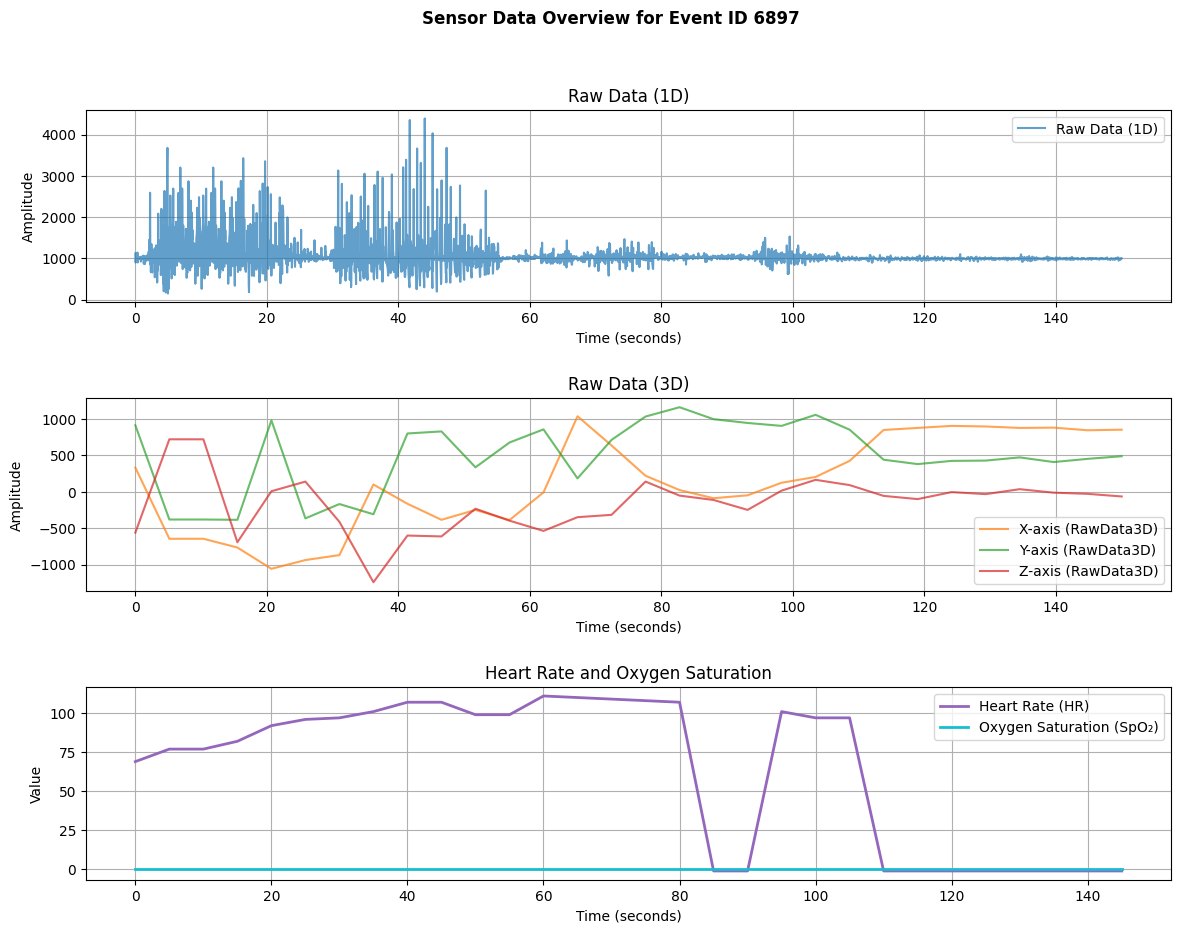

In [6]:
# Assuming df_sensordata is your dataframe containing sensor data
event_id = 6897  # Set the eventId 
sensor_df = df_sensordata  # Load the dataframe
filtered_data = sensor_df[sensor_df['eventId'] == event_id]  # Filter dataframe by the eventId

# Ensure there is data for the event
if filtered_data.empty:
    raise ValueError(f"No data found for event ID {event_id}")

# Extract rawData and rawData3D
raw_data = np.hstack(filtered_data['rawData'].dropna().values) if 'rawData' in filtered_data else np.array([])
raw_data3d = (
    np.vstack(filtered_data['rawData3D'].dropna().values)
    if 'rawData3D' in filtered_data and not filtered_data['rawData3D'].dropna().empty
    else np.array([])
)

# Extract HR and O2Sat data
hr = filtered_data['hr'].dropna().tolist()
o2_sat = filtered_data['o2Sat'].dropna().tolist()

# Define sample rates
raw_sample_rate = 125  # 125 samples per second for rawData and rawData3D
hr_spo2_sample_interval = 5  # HR and SpO₂ data sampled every 5 seconds

# Total number of rows for the event (each row is 5 seconds of data)
num_rows = len(filtered_data)

# Calculate the total duration for the event
total_duration = num_rows * 5  # Each row represents 5 seconds

# Generate the x-axis points for each dataset
time_raw_data = np.linspace(0, total_duration, len(raw_data))
time_raw_data3d = np.linspace(0, total_duration, len(raw_data3d))
time_hr_spo2 = np.arange(0, len(hr) * hr_spo2_sample_interval, hr_spo2_sample_interval)

# Create the plot with dynamic subplots
if raw_data3d.size > 0:  # If rawData3D is available, create 3 subplots
    subplot_ratios = [1, 1, 1]  # 33% each
    nrows = 3
else:  # Only rawData and HR/SpO₂
    subplot_ratios = [1, 1]  # 50% each
    nrows = 2

fig, axs = plt.subplots(
    nrows,
    1,
    figsize=(14, 10),
    gridspec_kw={'height_ratios': subplot_ratios, 'hspace': 0.5}  # Add space between plots
)
fig.suptitle(f"Sensor Data Overview for Event ID {event_id}", fontsize=12, fontweight='bold')

# Plot rawData on the first subplot
axs[0].plot(time_raw_data, raw_data, label="Raw Data (1D)", color='tab:blue', alpha=0.7)
axs[0].set_title("Raw Data (1D)")
axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid()

# Plot rawData3D on the second subplot if available
if raw_data3d.size > 0:
    axs[1].plot(time_raw_data3d, raw_data3d[:, 0], label="X-axis (RawData3D)", color='tab:orange', alpha=0.7)
    axs[1].plot(time_raw_data3d, raw_data3d[:, 1], label="Y-axis (RawData3D)", color='tab:green', alpha=0.7)
    axs[1].plot(time_raw_data3d, raw_data3d[:, 2], label="Z-axis (RawData3D)", color='tab:red', alpha=0.7)
    axs[1].set_title("Raw Data (3D)")
    axs[1].set_xlabel("Time (seconds)")
    axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    axs[1].grid()
else:
    print("rawData3D is empty or not available.")

# Plot HR and SpO₂ on the last subplot
hr_spo2_ax_index = 2 if raw_data3d.size > 0 else 1
if hr and o2_sat:
    axs[hr_spo2_ax_index].plot(time_hr_spo2, hr, label="Heart Rate (HR)", color='tab:purple', linewidth=2)
    axs[hr_spo2_ax_index].plot(time_hr_spo2, o2_sat, label="Oxygen Saturation (SpO₂)", color='tab:cyan', linewidth=2)
axs[hr_spo2_ax_index].set_title("Heart Rate and Oxygen Saturation")
axs[hr_spo2_ax_index].set_xlabel("Time (seconds)")
axs[hr_spo2_ax_index].set_ylabel("Value")
axs[hr_spo2_ax_index].legend()
axs[hr_spo2_ax_index].grid()

# Adjust layout and show the plot
plt.show()


## **6: Fast Fourier Transform and Region of Interest** 📈  

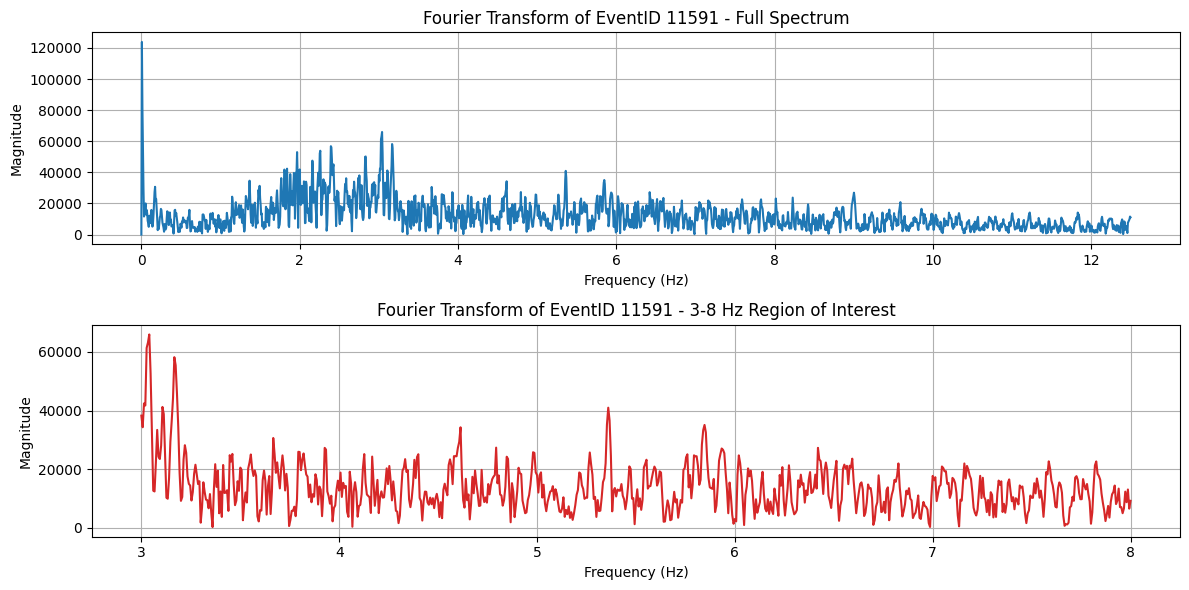

In [7]:
# Filter rows for eventId
event_id = 11591
filtered_data = df_sensordata[df_sensordata['eventId'] == event_id]

# Sampling frequency (25 Hz as per your clarification)
sampling_rate = 25  # in Hz

# FFT for each 5-second window (each row has 125 samples)
n_samples_per_row = 125  # Each row contains 125 samples (5 seconds * 25 Hz)
n_rows = len(filtered_data)

# Flatten the rawData column for all rows
raw_data = np.hstack(filtered_data['rawData'].values)

# Remove the DC component (mean of the signal)
raw_data = raw_data - np.mean(raw_data)

# Compute the Fourier Transform (FFT) for the entire signal
fft_result = np.fft.fft(raw_data)

# Compute the frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(raw_data), d=1/sampling_rate)

# Compute the magnitude of the FFT (absolute value)
fft_magnitude = np.abs(fft_result)

# Only consider the positive frequencies (the FFT is symmetric)
positive_frequencies = frequencies[:len(frequencies)//2]
positive_fft_magnitude = fft_magnitude[:len(frequencies)//2]

# Select the range of frequencies from 3 to 8 Hz (ROI)
roi_start = 3  # 3 Hz
roi_end = 8    # 8 Hz

# Find indices of the ROI frequencies
roi_indices = np.where((positive_frequencies >= roi_start) & (positive_frequencies <= roi_end))[0]

# Plot the FFT for the full spectrum and zoom into the 3-8 Hz region
plt.figure(figsize=(12, 6))

# Full spectrum plot
plt.subplot(2, 1, 1)
plt.plot(positive_frequencies, positive_fft_magnitude, color='tab:blue')
plt.title(f"Fourier Transform of EventID {event_id} - Full Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()

# Zoomed-in plot (3-8 Hz region)
plt.subplot(2, 1, 2)
plt.plot(positive_frequencies[roi_indices], positive_fft_magnitude[roi_indices], color='tab:red')
plt.title(f"Fourier Transform of EventID {event_id} - 3-8 Hz Region of Interest")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid()

plt.tight_layout()
plt.show()


## **7: Acceleration: Total Distance Travelled Per Timestep** 📈  

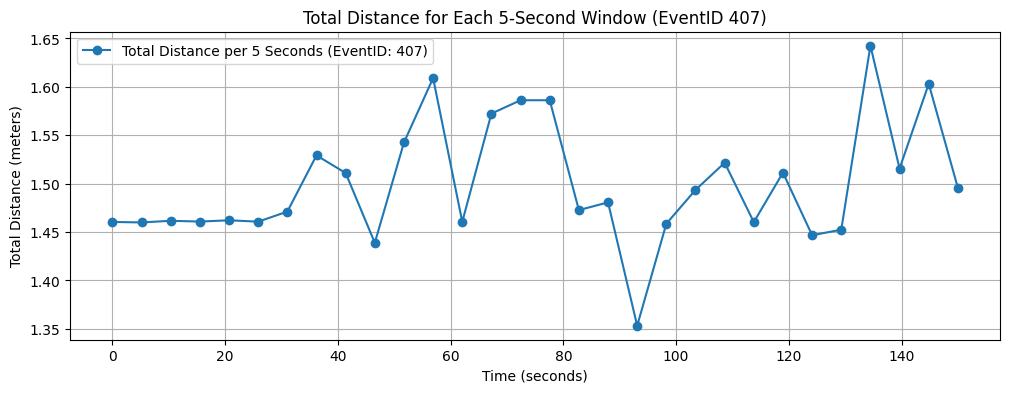

In [8]:
# Filter rows for eventId 407
event_id = 407
filtered_data = df_sensordata[df_sensordata['eventId'] == event_id]

# Total number of rows for the event
num_rows = len(filtered_data)

# Calculate total time (in seconds)
total_time = num_rows * 5

# Define sampling rate (25 Hz as mentioned earlier)
sampling_rate = 25

# Initialize an empty list to store total distances
total_distances = []

# Loop through each row and calculate the total distance for the 5-second window
for index, row in filtered_data.iterrows():
    # Get the rawData list and convert it to a numpy array
    raw_data = np.array(row['rawData'])  # This is a list of accelerations in milli-g
    
    # Convert from milli-g to m/s^2 (milli-g * 9.81 / 1000)
    raw_data_m_s2 = raw_data * (9.81 / 1000)
    
    # Calculate time step (1 / sampling rate)
    time_step = 1 / sampling_rate
    
    # Calculate distance traveled for each timestep: d = 0.5 * a * t^2
    # We square the time step and multiply by 0.5 times the acceleration
    distance_traveled = 0.5 * raw_data_m_s2 * time_step**2
    
    # Sum the distances for the entire 5-second window
    total_distance = np.sum(np.abs(distance_traveled))  # Absolute value to account for movement in any direction
    
    # Append the total distance to the list
    total_distances.append(total_distance)

# Convert the total_distances list to a NumPy array
total_distances = np.array(total_distances)

# Generate x-axis points (5 seconds per row)
time_points = np.linspace(0, total_time, num_rows)

# Plot total distance per timestep
plt.figure(figsize=(12, 4))
plt.plot(time_points, total_distances, marker='o', label=f"Total Distance per 5 Seconds (EventID: {event_id})", color='tab:blue')

# Add labels and title
plt.title(f"Total Distance for Each 5-Second Window (EventID {event_id})")
plt.xlabel("Time (seconds)")
plt.ylabel("Total Distance (meters)")
plt.legend()
plt.grid()

# Display the plot
plt.show()


## **8: Mel Spectorgram with 1D Acceleration Overlay** 📈  

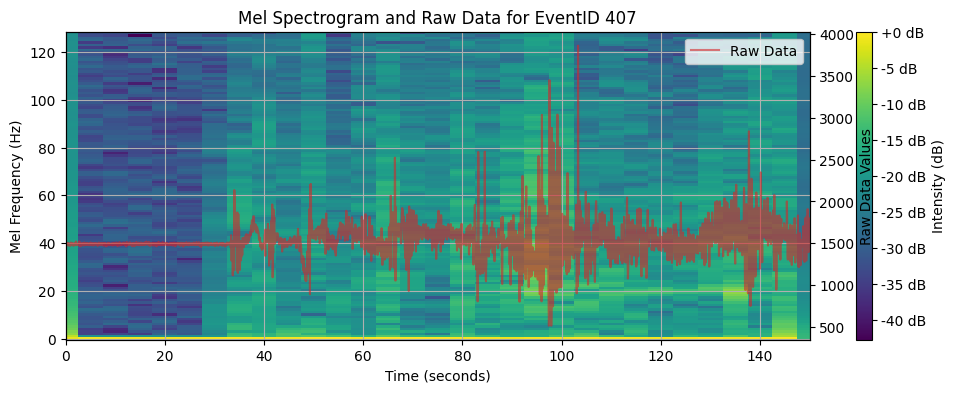

In [9]:
# Filter rows for eventId 407
event_id = 407
filtered_data = df_sensordata[df_sensordata['eventId'] == event_id]

# Total number of rows for the event
num_rows = len(filtered_data)

# Calculate total time (in seconds)
total_time = num_rows * 5

# Generate x-axis points for each rawData point
time_points = np.linspace(0, total_time, num_rows * 125)  # 125 values per row

# Flatten the rawData column for plotting and Mel Spectrogram
raw_data = np.hstack(filtered_data['rawData'].values)

# Sampling frequency (125 Hz based on the data)
sampling_rate = 125  # in Hz

# Apply Short-Time Fourier Transform (STFT) to the raw data
f, t, Zxx = signal.stft(raw_data, fs=sampling_rate, nperseg=256)

# Apply Mel filter bank to the magnitude of the STFT to create a Mel Spectrogram
mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(Zxx), sr=sampling_rate, n_mels=128)

# Convert to logarithmic scale (dB) for better visualization
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Normalize the x-axis of the spectrogram to match total_time
# Scale t to match the actual total time
spectrogram_time = np.linspace(0, total_time, log_mel_spectrogram.shape[1])

# Plot the Mel Spectrogram and Raw Data together
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plot the Mel Spectrogram
mappable = ax1.pcolormesh(
    spectrogram_time, 
    np.linspace(0, mel_spectrogram.shape[0], mel_spectrogram.shape[0]), 
    log_mel_spectrogram, 
    shading='auto', 
    cmap='viridis'
)
plt.colorbar(mappable, format='%+2.0f dB', ax=ax1, label="Intensity (dB)")
ax1.set_title(f'Mel Spectrogram and Raw Data for EventID {event_id}')
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Mel Frequency (Hz)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Create a second y-axis for the raw acceleration data
ax2 = ax1.twinx()

# Plot the raw acceleration data
ax2.plot(time_points, raw_data, color='tab:red', alpha=0.6, label='Raw Data')
ax2.set_ylabel("Raw Data Values", color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper right')

# Ensure x-axis for both plots matches the total duration
ax1.set_xlim(0, total_time)
ax2.set_xlim(0, total_time)

# Display the combined plot
plt.show()


## **9: Energy Per Frequency Band** 📈  

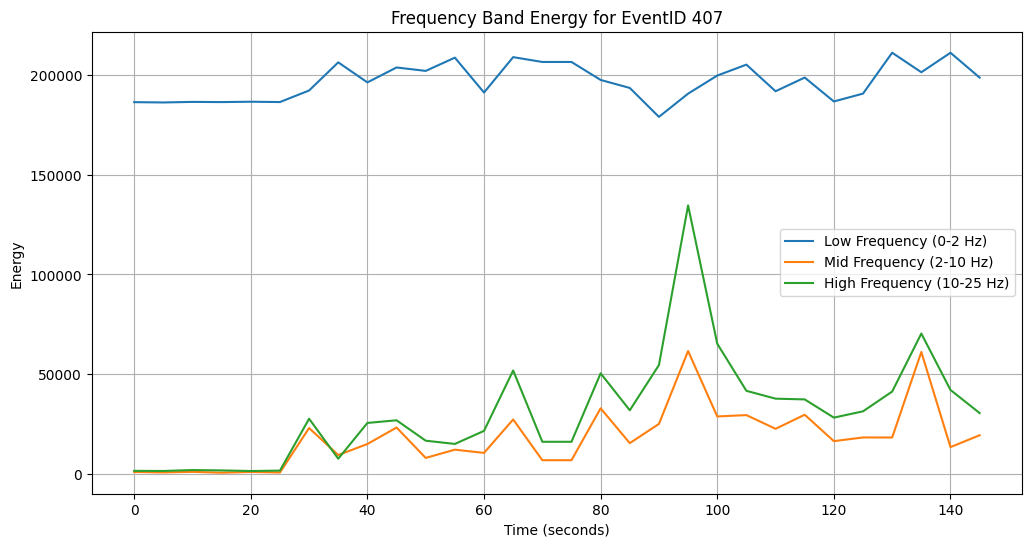

In [10]:
# Filter rows for eventId 407
event_id = 407
filtered_data = df_sensordata[df_sensordata['eventId'] == event_id]

# Total number of rows for the event
num_rows = len(filtered_data)

# Calculate total time (in seconds)
total_time = num_rows * 5

# Generate x-axis points for each rawData point
time_points = np.linspace(0, total_time, num_rows * 125)  # 125 samples per row

# Flatten the rawData column for plotting
raw_data = np.hstack(filtered_data['rawData'].values)

# Function to compute FFT and energy in frequency bands
def compute_frequency_bands(signal, fs=125):
    # Compute FFT of the signal
    fft_values = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), 1/fs)
    
    # Get the magnitude of the FFT
    fft_magnitude = np.abs(fft_values)
    
    # Define frequency bands (in Hz)
    low_freq_band = (0, 2)     # Low frequency: 0-2 Hz
    mid_freq_band = (2, 10)    # Mid frequency: 2-10 Hz
    high_freq_band = (10, 25)  # High frequency: 10-25 Hz
    
    # Compute energy in each frequency band
    low_energy = np.sum(fft_magnitude[(fft_freqs >= low_freq_band[0]) & (fft_freqs <= low_freq_band[1])])
    mid_energy = np.sum(fft_magnitude[(fft_freqs >= mid_freq_band[0]) & (fft_freqs <= mid_freq_band[1])])
    high_energy = np.sum(fft_magnitude[(fft_freqs >= high_freq_band[0]) & (fft_freqs <= high_freq_band[1])])
    
    return low_energy, mid_energy, high_energy

# Compute energy for each 5-second window and store results
low_energy_list = []
mid_energy_list = []
high_energy_list = []

for i in range(num_rows):
    # Extract raw data for the current row
    row_data = filtered_data.iloc[i]['rawData']
    
    # Compute energy for the current row using FFT
    low_energy, mid_energy, high_energy = compute_frequency_bands(row_data)
    
    # Store energy values for plotting
    low_energy_list.append(low_energy)
    mid_energy_list.append(mid_energy)
    high_energy_list.append(high_energy)

# Plot the relative energy of the frequency bands over time
plt.figure(figsize=(12, 6))
plt.plot(np.arange(num_rows) * 5, low_energy_list, label="Low Frequency (0-2 Hz)", color='tab:blue')
plt.plot(np.arange(num_rows) * 5, mid_energy_list, label="Mid Frequency (2-10 Hz)", color='tab:orange')
plt.plot(np.arange(num_rows) * 5, high_energy_list, label="High Frequency (10-25 Hz)", color='tab:green')

# Add labels and title
plt.title(f"Frequency Band Energy for EventID {event_id}")
plt.xlabel("Time (seconds)")
plt.ylabel("Energy")
plt.legend()
plt.grid()

# Display the plot
plt.show()


## **10: Skewness and Kurtosis** 📈 

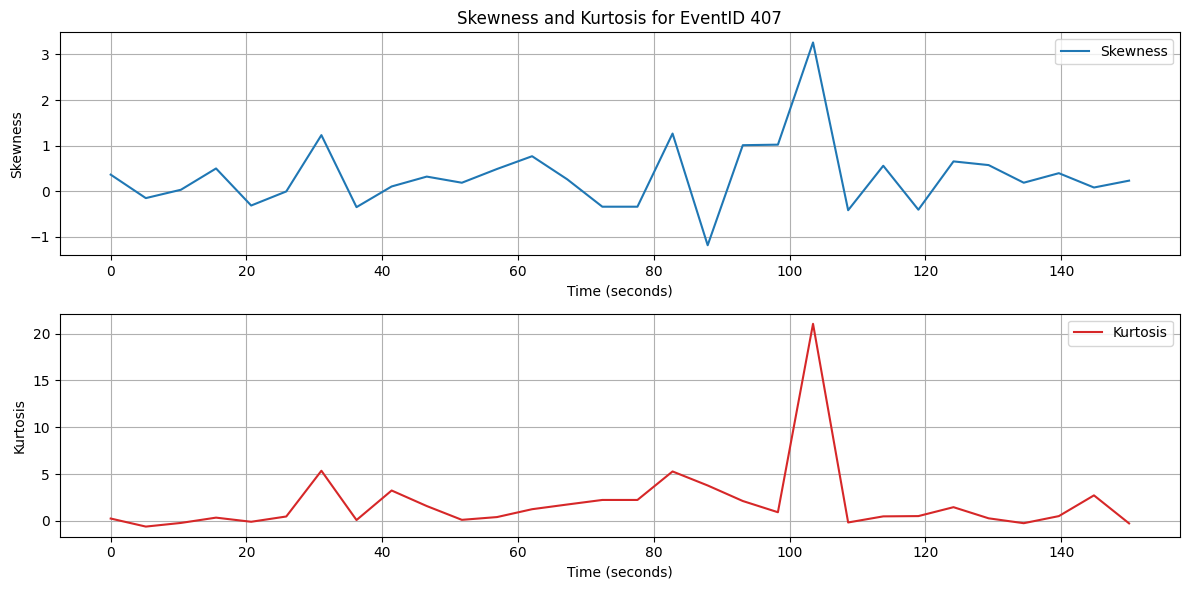

In [11]:
# Filter rows for eventId 407
event_id = 407
filtered_data = df_sensordata[df_sensordata['eventId'] == event_id]

# Total number of rows for the event
num_rows = len(filtered_data)

# Lists to store skewness and kurtosis values for each row
skewness_values = []
kurtosis_values = []

# Compute skewness and kurtosis for each row
for i in range(num_rows):
    # Extract raw data for the current row
    row_data = filtered_data.iloc[i]['rawData']
    
    # Compute skewness and kurtosis for the current row
    skewness_values.append(skew(row_data))
    kurtosis_values.append(kurtosis(row_data))

# Generate the time axis for plotting
time_axis = np.linspace(0, num_rows * 5, num_rows)

# Plot skewness and kurtosis values
plt.figure(figsize=(12, 6))

# Plot skewness
plt.subplot(2, 1, 1)
plt.plot(time_axis, skewness_values, label="Skewness", color='tab:blue')
plt.title(f"Skewness and Kurtosis for EventID {event_id}")
plt.xlabel("Time (seconds)")
plt.ylabel("Skewness")
plt.legend()
plt.grid()

# Plot kurtosis
plt.subplot(2, 1, 2)
plt.plot(time_axis, kurtosis_values, label="Kurtosis", color='tab:red')
plt.xlabel("Time (seconds)")
plt.ylabel("Kurtosis")
plt.legend()
plt.grid()

# Display the plots
plt.tight_layout()
plt.show()


## **11: STD and max acceleration** 📈 

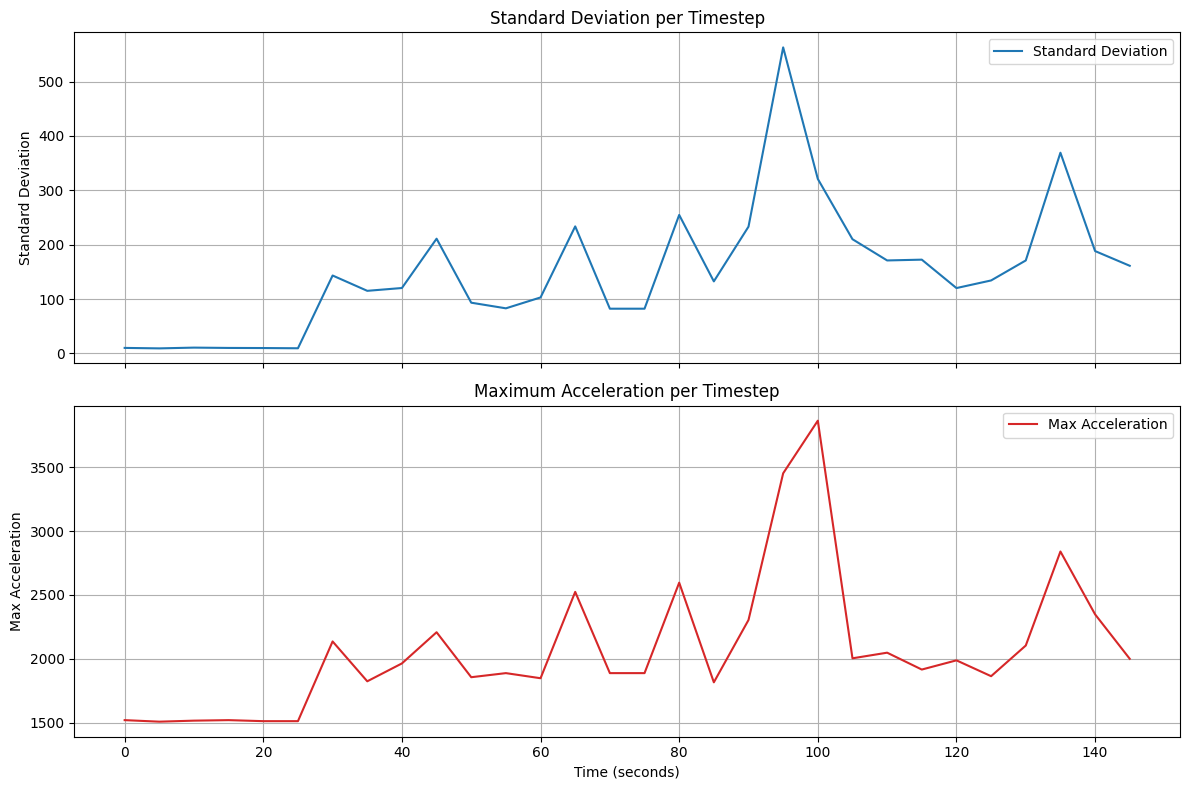

In [12]:
# Extract rawData (1D array) and ensure it's not empty
raw_data = np.hstack(filtered_data['rawData'].dropna().values) if 'rawData' in filtered_data else np.array([])

# Ensure there is data for rawData
if raw_data.size == 0:
    raise ValueError("No rawData found for the given eventId")

# Number of timesteps (assuming 30)
num_timesteps = len(filtered_data)  # This should be 30 in your case (30 rows for 30 timesteps)

# Time axis (assuming 5 seconds per timestep)
time_axis = np.arange(0, num_timesteps * 5, 5)

# Now, we calculate the standard deviation and max acceleration per timestep

# Calculate the standard deviation for each timestep (assuming each timestep has a fixed number of values)
std_values = []
max_acceleration = []

# Assuming each timestep has `x` number of data points
timesteps_length = len(raw_data) // num_timesteps

for i in range(num_timesteps):
    # Get the data for the current timestep
    timestep_data = raw_data[i * timesteps_length:(i + 1) * timesteps_length]
    
    # Calculate the standard deviation for this timestep
    std_values.append(np.std(timestep_data))  # Standard deviation
    
    # Calculate the maximum acceleration for this timestep
    max_acceleration.append(np.max(timestep_data))  # Max acceleration

# Plot the STD and max acceleration in two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the standard deviation for each timestep
axs[0].plot(time_axis, std_values, label="Standard Deviation", color='tab:blue')
axs[0].set_ylabel("Standard Deviation")
axs[0].set_title("Standard Deviation per Timestep")
axs[0].grid(True)
axs[0].legend()

# Plot the maximum acceleration for each timestep
axs[1].plot(time_axis, max_acceleration, label="Max Acceleration", color='tab:red')
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Max Acceleration")
axs[1].set_title("Maximum Acceleration per Timestep")
axs[1].grid(True)
axs[1].legend()

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
